In [1]:
import os
import random
os.environ["KMP_DUPLICATE_LIB_OK"]="True"
import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from resnet_yolo import resnet50
from yolo_loss import YoloLoss
from dataset import VocDetectorDataset
from eval_voc import evaluate
from predict import predict_image
from config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assignment3 Part2: Yolo Detection

We provide you a Yolo Detection network implementation, which is not finished. You are asked to complete the implementation by writing the loss function.

## What to do
You are asked to implement the loss function in ```yolo_loss.py```. You can use ```yolo_loss_debug_tool.ipynb``` to help you debug.

## What to submit
See the submission template for what to submit.

## Initialization

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effictively.

In [4]:
load_network_path = None
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


In [5]:
learning_rate = 0.001
num_epochs = 50
batch_size = 12

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

In [6]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection dataset since the bounding box annotations must be kept consistent through the transformations.

Since the output of the dector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [7]:
file_root_train = 'VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [27]:
file_root_test = 'VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


## Train detector

In [9]:
best_test_loss = np.inf

for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = 0.
    
    for i, (images, target) in enumerate(train_loader):
        images, target = images.to(device), target.to(device)
        
        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f'
                  % (epoch+1, num_epochs, i+1, len(train_loader), loss.item(), total_loss / (i+1)))

    if epoch % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test)
            
    # evaluate the network on the test data
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            pred = net(images)
            loss = criterion(pred,target)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'best_detector.pth')

    torch.save(net.state_dict(),'detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [5/418] Loss: 65.3886, average_loss: 69.6646
Epoch [1/50], Iter [10/418] Loss: 49.2433, average_loss: 61.1423
Epoch [1/50], Iter [15/418] Loss: 24.2163, average_loss: 51.7503
Epoch [1/50], Iter [20/418] Loss: 22.1707, average_loss: 44.2904
Epoch [1/50], Iter [25/418] Loss: 14.9132, average_loss: 38.3107
Epoch [1/50], Iter [30/418] Loss: 20.6197, average_loss: 34.2178
Epoch [1/50], Iter [35/418] Loss: 11.5318, average_loss: 31.0002
Epoch [1/50], Iter [40/418] Loss: 9.8201, average_loss: 28.7125
Epoch [1/50], Iter [45/418] Loss: 18.3350, average_loss: 27.1103
Epoch [1/50], Iter [50/418] Loss: 6.5053, average_loss: 25.3286
Epoch [1/50], Iter [55/418] Loss: 11.8547, average_loss: 23.9545
Epoch [1/50], Iter [60/418] Loss: 12.0990, average_loss: 22.7367
Epoch [1/50], Iter [65/418] Loss: 11.4756, average_loss: 21.8248
Epoch [1/50], Iter [70/418] Loss: 10.4918, average_loss: 20.9617
Epoch [1/50], Iter [75/418] Loss:

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.14it/s]


---class aeroplane ap 0.0---
---class bicycle ap 0.0--- (no predictions for this class)
---class bird ap 0.0--- (no predictions for this class)
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.0--- (no predictions for this class)
---class bus ap 0.0--- (no predictions for this class)
---class car ap 0.0--- (no predictions for this class)
---class cat ap 0.0--- (no predictions for this class)
---class chair ap 0.0--- (no predictions for this class)
---class cow ap 0.0--- (no predictions for this class)
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.0--- (no predictions for this class)
---class horse ap 0.0--- (no predictions for this class)
---class motorbike ap 0.0--- (no predictions for this class)
---class person ap 0.0--- (no predictions for this class)
---class pottedplant ap 0.0--- (no predictions for this class)
---class sheep ap 0.0--- (no predictions for this class)
---class sofa ap 0.0--- (no predictions for this cl

Epoch [3/50], Iter [130/418] Loss: 4.3389, average_loss: 4.5568
Epoch [3/50], Iter [135/418] Loss: 2.8437, average_loss: 4.5413
Epoch [3/50], Iter [140/418] Loss: 3.2526, average_loss: 4.5428
Epoch [3/50], Iter [145/418] Loss: 4.8177, average_loss: 4.5529
Epoch [3/50], Iter [150/418] Loss: 4.3235, average_loss: 4.5303
Epoch [3/50], Iter [155/418] Loss: 5.9535, average_loss: 4.5399
Epoch [3/50], Iter [160/418] Loss: 4.3890, average_loss: 4.5478
Epoch [3/50], Iter [165/418] Loss: 4.5106, average_loss: 4.5338
Epoch [3/50], Iter [170/418] Loss: 3.5480, average_loss: 4.5248
Epoch [3/50], Iter [175/418] Loss: 6.5841, average_loss: 4.5610
Epoch [3/50], Iter [180/418] Loss: 2.8220, average_loss: 4.5391
Epoch [3/50], Iter [185/418] Loss: 4.7179, average_loss: 4.5535
Epoch [3/50], Iter [190/418] Loss: 4.6823, average_loss: 4.5434
Epoch [3/50], Iter [195/418] Loss: 3.8117, average_loss: 4.5413
Epoch [3/50], Iter [200/418] Loss: 2.4689, average_loss: 4.5328
Epoch [3/50], Iter [205/418] Loss: 3.490

Epoch [4/50], Iter [350/418] Loss: 3.1015, average_loss: 4.2240
Epoch [4/50], Iter [355/418] Loss: 5.8859, average_loss: 4.2171
Epoch [4/50], Iter [360/418] Loss: 3.5438, average_loss: 4.2183
Epoch [4/50], Iter [365/418] Loss: 7.1728, average_loss: 4.2301
Epoch [4/50], Iter [370/418] Loss: 3.7846, average_loss: 4.2272
Epoch [4/50], Iter [375/418] Loss: 2.9472, average_loss: 4.2243
Epoch [4/50], Iter [380/418] Loss: 3.5004, average_loss: 4.2260
Epoch [4/50], Iter [385/418] Loss: 6.8226, average_loss: 4.2320
Epoch [4/50], Iter [390/418] Loss: 5.5190, average_loss: 4.2322
Epoch [4/50], Iter [395/418] Loss: 3.4931, average_loss: 4.2334
Epoch [4/50], Iter [400/418] Loss: 3.3819, average_loss: 4.2286
Epoch [4/50], Iter [405/418] Loss: 4.9963, average_loss: 4.2298
Epoch [4/50], Iter [410/418] Loss: 3.2393, average_loss: 4.2218
Epoch [4/50], Iter [415/418] Loss: 3.7674, average_loss: 4.2144
Updating best test loss: 4.17308


Starting epoch 5 / 50
Learning Rate for this epoch: 0.001
Epoch [5/50

Epoch [6/50], Iter [150/418] Loss: 3.4994, average_loss: 3.8038
Epoch [6/50], Iter [155/418] Loss: 2.7455, average_loss: 3.7997
Epoch [6/50], Iter [160/418] Loss: 3.1955, average_loss: 3.7915
Epoch [6/50], Iter [165/418] Loss: 2.9819, average_loss: 3.7745
Epoch [6/50], Iter [170/418] Loss: 4.9026, average_loss: 3.7623
Epoch [6/50], Iter [175/418] Loss: 3.6340, average_loss: 3.7560
Epoch [6/50], Iter [180/418] Loss: 5.3586, average_loss: 3.7590
Epoch [6/50], Iter [185/418] Loss: 3.5363, average_loss: 3.7494
Epoch [6/50], Iter [190/418] Loss: 2.7080, average_loss: 3.7310
Epoch [6/50], Iter [195/418] Loss: 2.7576, average_loss: 3.7421
Epoch [6/50], Iter [200/418] Loss: 3.6262, average_loss: 3.7420
Epoch [6/50], Iter [205/418] Loss: 3.0959, average_loss: 3.7191
Epoch [6/50], Iter [210/418] Loss: 3.7525, average_loss: 3.7130
Epoch [6/50], Iter [215/418] Loss: 6.1116, average_loss: 3.7197
Epoch [6/50], Iter [220/418] Loss: 4.0766, average_loss: 3.7288
Epoch [6/50], Iter [225/418] Loss: 2.683

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:26<00:00, 33.68it/s]


---class aeroplane ap 0.15677445321987085---
---class bicycle ap 0.13549403809197724---
---class bird ap 0.023484656250711153---
---class boat ap 0.0--- (no predictions for this class)
---class bottle ap 0.010457710171351269---
---class bus ap 0.06287979593809999---
---class car ap 0.3196125223822618---
---class cat ap 0.10284463089006092---
---class chair ap 0.061336566931985095---
---class cow ap 0.011270491803278689---
---class diningtable ap 0.0--- (no predictions for this class)
---class dog ap 0.005112474437627812---
---class horse ap 0.11084328502102064---
---class motorbike ap 0.020384615384615383---
---class person ap 0.21305105875684155---
---class pottedplant ap 0.015939401066282267---
---class sheep ap 0.03926462040240236---
---class sofa ap 0.0--- (no predictions for this class)
---class train ap 0.2684100173468424---
---class tvmonitor ap 0.10459685076236552---
---map 0.08308785944287975---
Updating best test loss: 3.81385


Starting epoch 7 / 50
Learning Rate for this ep

Epoch [8/50], Iter [150/418] Loss: 2.8376, average_loss: 3.4904
Epoch [8/50], Iter [155/418] Loss: 2.2811, average_loss: 3.4815
Epoch [8/50], Iter [160/418] Loss: 2.7052, average_loss: 3.4733
Epoch [8/50], Iter [165/418] Loss: 2.5953, average_loss: 3.4838
Epoch [8/50], Iter [170/418] Loss: 2.5935, average_loss: 3.4812
Epoch [8/50], Iter [175/418] Loss: 4.2614, average_loss: 3.4815
Epoch [8/50], Iter [180/418] Loss: 3.2196, average_loss: 3.4802
Epoch [8/50], Iter [185/418] Loss: 2.5211, average_loss: 3.4808
Epoch [8/50], Iter [190/418] Loss: 3.7939, average_loss: 3.4826
Epoch [8/50], Iter [195/418] Loss: 2.9917, average_loss: 3.4801
Epoch [8/50], Iter [200/418] Loss: 2.8497, average_loss: 3.4950
Epoch [8/50], Iter [205/418] Loss: 2.6941, average_loss: 3.5055
Epoch [8/50], Iter [210/418] Loss: 3.9694, average_loss: 3.5041
Epoch [8/50], Iter [215/418] Loss: 2.7054, average_loss: 3.4866
Epoch [8/50], Iter [220/418] Loss: 2.7483, average_loss: 3.4807
Epoch [8/50], Iter [225/418] Loss: 3.286

Epoch [9/50], Iter [370/418] Loss: 2.3765, average_loss: 3.2701
Epoch [9/50], Iter [375/418] Loss: 4.1497, average_loss: 3.2726
Epoch [9/50], Iter [380/418] Loss: 2.9217, average_loss: 3.2672
Epoch [9/50], Iter [385/418] Loss: 2.6831, average_loss: 3.2656
Epoch [9/50], Iter [390/418] Loss: 4.6947, average_loss: 3.2679
Epoch [9/50], Iter [395/418] Loss: 3.2749, average_loss: 3.2632
Epoch [9/50], Iter [400/418] Loss: 6.6673, average_loss: 3.2664
Epoch [9/50], Iter [405/418] Loss: 2.1805, average_loss: 3.2643
Epoch [9/50], Iter [410/418] Loss: 1.7253, average_loss: 3.2611
Epoch [9/50], Iter [415/418] Loss: 5.5722, average_loss: 3.2685
Updating best test loss: 3.36789


Starting epoch 10 / 50
Learning Rate for this epoch: 0.001
Epoch [10/50], Iter [5/418] Loss: 4.9394, average_loss: 3.9492
Epoch [10/50], Iter [10/418] Loss: 3.5021, average_loss: 3.3124
Epoch [10/50], Iter [15/418] Loss: 4.0345, average_loss: 3.3328
Epoch [10/50], Iter [20/418] Loss: 2.7531, average_loss: 3.1943
Epoch [10/5

Epoch [11/50], Iter [160/418] Loss: 3.7208, average_loss: 3.1389
Epoch [11/50], Iter [165/418] Loss: 4.2522, average_loss: 3.1619
Epoch [11/50], Iter [170/418] Loss: 1.9443, average_loss: 3.1653
Epoch [11/50], Iter [175/418] Loss: 2.7555, average_loss: 3.1639
Epoch [11/50], Iter [180/418] Loss: 1.6121, average_loss: 3.1653
Epoch [11/50], Iter [185/418] Loss: 3.6224, average_loss: 3.1624
Epoch [11/50], Iter [190/418] Loss: 2.0980, average_loss: 3.1532
Epoch [11/50], Iter [195/418] Loss: 3.1885, average_loss: 3.1441
Epoch [11/50], Iter [200/418] Loss: 4.1407, average_loss: 3.1389
Epoch [11/50], Iter [205/418] Loss: 2.1039, average_loss: 3.1321
Epoch [11/50], Iter [210/418] Loss: 2.6335, average_loss: 3.1408
Epoch [11/50], Iter [215/418] Loss: 1.8697, average_loss: 3.1226
Epoch [11/50], Iter [220/418] Loss: 3.0301, average_loss: 3.1237
Epoch [11/50], Iter [225/418] Loss: 2.4267, average_loss: 3.1124
Epoch [11/50], Iter [230/418] Loss: 2.7600, average_loss: 3.1088
Epoch [11/50], Iter [235/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.08it/s]


---class aeroplane ap 0.295768783763334---
---class bicycle ap 0.379346323328453---
---class bird ap 0.21685817174478597---
---class boat ap 0.08592000761755941---
---class bottle ap 0.09926367245828573---
---class bus ap 0.4143307026801051---
---class car ap 0.495194614373971---
---class cat ap 0.4316385932822256---
---class chair ap 0.16143781328898357---
---class cow ap 0.1863496011073207---
---class diningtable ap 0.07069603805040697---
---class dog ap 0.3623213598647317---
---class horse ap 0.4263373915114903---
---class motorbike ap 0.4032274274228236---
---class person ap 0.3413324331753324---
---class pottedplant ap 0.05729249903321587---
---class sheep ap 0.20048851302312976---
---class sofa ap 0.2091141166722329---
---class train ap 0.4335083517167603---
---class tvmonitor ap 0.34211508592680906---
---map 0.2806270750020979---
Updating best test loss: 3.15290


Starting epoch 12 / 50
Learning Rate for this epoch: 0.001
Epoch [12/50], Iter [5/418] Loss: 2.8690, average_loss: 3

Epoch [13/50], Iter [145/418] Loss: 2.3493, average_loss: 2.8175
Epoch [13/50], Iter [150/418] Loss: 2.9947, average_loss: 2.8196
Epoch [13/50], Iter [155/418] Loss: 2.4415, average_loss: 2.8141
Epoch [13/50], Iter [160/418] Loss: 2.5704, average_loss: 2.7949
Epoch [13/50], Iter [165/418] Loss: 2.8933, average_loss: 2.7850
Epoch [13/50], Iter [170/418] Loss: 4.3753, average_loss: 2.8004
Epoch [13/50], Iter [175/418] Loss: 2.3534, average_loss: 2.8016
Epoch [13/50], Iter [180/418] Loss: 2.0969, average_loss: 2.8029
Epoch [13/50], Iter [185/418] Loss: 3.3142, average_loss: 2.7973
Epoch [13/50], Iter [190/418] Loss: 2.2393, average_loss: 2.8043
Epoch [13/50], Iter [195/418] Loss: 2.3645, average_loss: 2.7965
Epoch [13/50], Iter [200/418] Loss: 2.0853, average_loss: 2.7975
Epoch [13/50], Iter [205/418] Loss: 2.0896, average_loss: 2.7921
Epoch [13/50], Iter [210/418] Loss: 3.1458, average_loss: 2.8010
Epoch [13/50], Iter [215/418] Loss: 2.0046, average_loss: 2.8078
Epoch [13/50], Iter [220/

Epoch [14/50], Iter [355/418] Loss: 3.2459, average_loss: 2.7984
Epoch [14/50], Iter [360/418] Loss: 2.6892, average_loss: 2.7949
Epoch [14/50], Iter [365/418] Loss: 3.3953, average_loss: 2.7892
Epoch [14/50], Iter [370/418] Loss: 5.1694, average_loss: 2.7929
Epoch [14/50], Iter [375/418] Loss: 2.0468, average_loss: 2.7881
Epoch [14/50], Iter [380/418] Loss: 2.4253, average_loss: 2.7922
Epoch [14/50], Iter [385/418] Loss: 1.9663, average_loss: 2.7934
Epoch [14/50], Iter [390/418] Loss: 2.4924, average_loss: 2.7939
Epoch [14/50], Iter [395/418] Loss: 2.9653, average_loss: 2.7918
Epoch [14/50], Iter [400/418] Loss: 3.7740, average_loss: 2.7946
Epoch [14/50], Iter [405/418] Loss: 2.0498, average_loss: 2.7924
Epoch [14/50], Iter [410/418] Loss: 1.7532, average_loss: 2.7865
Epoch [14/50], Iter [415/418] Loss: 2.0069, average_loss: 2.7826
Updating best test loss: 3.02143


Starting epoch 15 / 50
Learning Rate for this epoch: 0.001
Epoch [15/50], Iter [5/418] Loss: 2.9903, average_loss: 2.917

Epoch [16/50], Iter [145/418] Loss: 1.9086, average_loss: 2.6313
Epoch [16/50], Iter [150/418] Loss: 2.1584, average_loss: 2.6452
Epoch [16/50], Iter [155/418] Loss: 1.5105, average_loss: 2.6330
Epoch [16/50], Iter [160/418] Loss: 2.0077, average_loss: 2.6134
Epoch [16/50], Iter [165/418] Loss: 1.0132, average_loss: 2.6105
Epoch [16/50], Iter [170/418] Loss: 1.5500, average_loss: 2.5943
Epoch [16/50], Iter [175/418] Loss: 2.2440, average_loss: 2.5987
Epoch [16/50], Iter [180/418] Loss: 2.7324, average_loss: 2.5987
Epoch [16/50], Iter [185/418] Loss: 2.3496, average_loss: 2.6027
Epoch [16/50], Iter [190/418] Loss: 2.4032, average_loss: 2.6041
Epoch [16/50], Iter [195/418] Loss: 2.5855, average_loss: 2.6070
Epoch [16/50], Iter [200/418] Loss: 3.6567, average_loss: 2.6094
Epoch [16/50], Iter [205/418] Loss: 2.5860, average_loss: 2.6056
Epoch [16/50], Iter [210/418] Loss: 2.4169, average_loss: 2.6137
Epoch [16/50], Iter [215/418] Loss: 3.9758, average_loss: 2.6078
Epoch [16/50], Iter [220/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:30<00:00, 32.88it/s]


---class aeroplane ap 0.37285237585051584---
---class bicycle ap 0.4676476861537768---
---class bird ap 0.3666061847331922---
---class boat ap 0.1720380810682079---
---class bottle ap 0.08349009627502596---
---class bus ap 0.4795882875416946---
---class car ap 0.5241351875104908---
---class cat ap 0.5858728484348155---
---class chair ap 0.25888455849634606---
---class cow ap 0.30679627675630644---
---class diningtable ap 0.2560731423059066---
---class dog ap 0.4517628216903178---
---class horse ap 0.5170806115703241---
---class motorbike ap 0.465489037802489---
---class person ap 0.4373157071527014---
---class pottedplant ap 0.09873670510741604---
---class sheep ap 0.31648684428543783---
---class sofa ap 0.3730579164937942---
---class train ap 0.5454691090488633---
---class tvmonitor ap 0.39109766651241157---
---map 0.37352405723950166---
Updating best test loss: 2.93706


Starting epoch 17 / 50
Learning Rate for this epoch: 0.001
Epoch [17/50], Iter [5/418] Loss: 2.0921, average_loss:

Epoch [18/50], Iter [145/418] Loss: 2.0425, average_loss: 2.5008
Epoch [18/50], Iter [150/418] Loss: 2.2185, average_loss: 2.5109
Epoch [18/50], Iter [155/418] Loss: 2.5697, average_loss: 2.5058
Epoch [18/50], Iter [160/418] Loss: 2.5902, average_loss: 2.5065
Epoch [18/50], Iter [165/418] Loss: 1.9834, average_loss: 2.5034
Epoch [18/50], Iter [170/418] Loss: 2.3721, average_loss: 2.4970
Epoch [18/50], Iter [175/418] Loss: 2.8074, average_loss: 2.4945
Epoch [18/50], Iter [180/418] Loss: 2.7699, average_loss: 2.5008
Epoch [18/50], Iter [185/418] Loss: 1.9149, average_loss: 2.4998
Epoch [18/50], Iter [190/418] Loss: 2.5321, average_loss: 2.4931
Epoch [18/50], Iter [195/418] Loss: 4.2122, average_loss: 2.5030
Epoch [18/50], Iter [200/418] Loss: 2.3172, average_loss: 2.5090
Epoch [18/50], Iter [205/418] Loss: 2.1862, average_loss: 2.4928
Epoch [18/50], Iter [210/418] Loss: 2.5889, average_loss: 2.5123
Epoch [18/50], Iter [215/418] Loss: 2.3813, average_loss: 2.5254
Epoch [18/50], Iter [220/

Epoch [19/50], Iter [355/418] Loss: 2.5822, average_loss: 2.4321
Epoch [19/50], Iter [360/418] Loss: 2.0580, average_loss: 2.4302
Epoch [19/50], Iter [365/418] Loss: 2.6328, average_loss: 2.4335
Epoch [19/50], Iter [370/418] Loss: 2.6210, average_loss: 2.4297
Epoch [19/50], Iter [375/418] Loss: 3.0566, average_loss: 2.4332
Epoch [19/50], Iter [380/418] Loss: 2.4982, average_loss: 2.4315
Epoch [19/50], Iter [385/418] Loss: 2.5095, average_loss: 2.4308
Epoch [19/50], Iter [390/418] Loss: 1.8211, average_loss: 2.4296
Epoch [19/50], Iter [395/418] Loss: 2.4225, average_loss: 2.4309
Epoch [19/50], Iter [400/418] Loss: 2.3501, average_loss: 2.4321
Epoch [19/50], Iter [405/418] Loss: 2.2268, average_loss: 2.4291
Epoch [19/50], Iter [410/418] Loss: 2.0651, average_loss: 2.4292
Epoch [19/50], Iter [415/418] Loss: 2.0902, average_loss: 2.4264
Updating best test loss: 2.87671


Starting epoch 20 / 50
Learning Rate for this epoch: 0.001
Epoch [20/50], Iter [5/418] Loss: 1.5387, average_loss: 2.243

Epoch [21/50], Iter [145/418] Loss: 2.4830, average_loss: 2.2511
Epoch [21/50], Iter [150/418] Loss: 2.0430, average_loss: 2.2451
Epoch [21/50], Iter [155/418] Loss: 3.0151, average_loss: 2.2555
Epoch [21/50], Iter [160/418] Loss: 2.7854, average_loss: 2.2785
Epoch [21/50], Iter [165/418] Loss: 2.1272, average_loss: 2.2846
Epoch [21/50], Iter [170/418] Loss: 2.9167, average_loss: 2.3000
Epoch [21/50], Iter [175/418] Loss: 1.5975, average_loss: 2.2992
Epoch [21/50], Iter [180/418] Loss: 2.7753, average_loss: 2.3193
Epoch [21/50], Iter [185/418] Loss: 1.9413, average_loss: 2.3159
Epoch [21/50], Iter [190/418] Loss: 2.2019, average_loss: 2.3103
Epoch [21/50], Iter [195/418] Loss: 2.8550, average_loss: 2.3097
Epoch [21/50], Iter [200/418] Loss: 2.8200, average_loss: 2.3180
Epoch [21/50], Iter [205/418] Loss: 2.5447, average_loss: 2.3155
Epoch [21/50], Iter [210/418] Loss: 2.1417, average_loss: 2.3138
Epoch [21/50], Iter [215/418] Loss: 2.2687, average_loss: 2.3274
Epoch [21/50], Iter [220/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.00it/s]


---class aeroplane ap 0.49527723916354427---
---class bicycle ap 0.554469262967542---
---class bird ap 0.4088712338637629---
---class boat ap 0.22445096250553298---
---class bottle ap 0.2001294240391368---
---class bus ap 0.5644049611547959---
---class car ap 0.591911072442602---
---class cat ap 0.5595001508798307---
---class chair ap 0.23199019097062606---
---class cow ap 0.3882388480738114---
---class diningtable ap 0.23400138175311888---
---class dog ap 0.5236995882063804---
---class horse ap 0.5779228278500603---
---class motorbike ap 0.5070554144826592---
---class person ap 0.44300151371755936---
---class pottedplant ap 0.1455522655229368---
---class sheep ap 0.3716933873709764---
---class sofa ap 0.41868268911529977---
---class train ap 0.5991360083357484---
---class tvmonitor ap 0.4115268155031486---
---map 0.4225757618959536---
Updating best test loss: 2.81465


Starting epoch 22 / 50
Learning Rate for this epoch: 0.001
Epoch [22/50], Iter [5/418] Loss: 1.9292, average_loss: 2.

Epoch [23/50], Iter [150/418] Loss: 2.4672, average_loss: 2.2968
Epoch [23/50], Iter [155/418] Loss: 2.3756, average_loss: 2.3074
Epoch [23/50], Iter [160/418] Loss: 2.1116, average_loss: 2.3026
Epoch [23/50], Iter [165/418] Loss: 2.6197, average_loss: 2.3150
Epoch [23/50], Iter [170/418] Loss: 1.8670, average_loss: 2.3051
Epoch [23/50], Iter [175/418] Loss: 1.6712, average_loss: 2.3007
Epoch [23/50], Iter [180/418] Loss: 2.0089, average_loss: 2.3012
Epoch [23/50], Iter [185/418] Loss: 1.7749, average_loss: 2.2980
Epoch [23/50], Iter [190/418] Loss: 1.9438, average_loss: 2.3045
Epoch [23/50], Iter [195/418] Loss: 2.5775, average_loss: 2.2877
Epoch [23/50], Iter [200/418] Loss: 2.0360, average_loss: 2.3000
Epoch [23/50], Iter [205/418] Loss: 1.5873, average_loss: 2.2894
Epoch [23/50], Iter [210/418] Loss: 3.0565, average_loss: 2.2957
Epoch [23/50], Iter [215/418] Loss: 1.8618, average_loss: 2.2969
Epoch [23/50], Iter [220/418] Loss: 2.1546, average_loss: 2.3019
Epoch [23/50], Iter [225/

Epoch [24/50], Iter [360/418] Loss: 2.6496, average_loss: 2.2487
Epoch [24/50], Iter [365/418] Loss: 2.8846, average_loss: 2.2495
Epoch [24/50], Iter [370/418] Loss: 1.9950, average_loss: 2.2480
Epoch [24/50], Iter [375/418] Loss: 2.4582, average_loss: 2.2536
Epoch [24/50], Iter [380/418] Loss: 2.7444, average_loss: 2.2566
Epoch [24/50], Iter [385/418] Loss: 2.6421, average_loss: 2.2548
Epoch [24/50], Iter [390/418] Loss: 2.3332, average_loss: 2.2500
Epoch [24/50], Iter [395/418] Loss: 1.8523, average_loss: 2.2533
Epoch [24/50], Iter [400/418] Loss: 1.9688, average_loss: 2.2524
Epoch [24/50], Iter [405/418] Loss: 2.1050, average_loss: 2.2519
Epoch [24/50], Iter [410/418] Loss: 3.3869, average_loss: 2.2548
Epoch [24/50], Iter [415/418] Loss: 3.4004, average_loss: 2.2578
Updating best test loss: 2.77750


Starting epoch 25 / 50
Learning Rate for this epoch: 0.001
Epoch [25/50], Iter [5/418] Loss: 2.4302, average_loss: 2.5265
Epoch [25/50], Iter [10/418] Loss: 1.5543, average_loss: 2.2862

Epoch [26/50], Iter [150/418] Loss: 1.7492, average_loss: 2.1509
Epoch [26/50], Iter [155/418] Loss: 2.0997, average_loss: 2.1485
Epoch [26/50], Iter [160/418] Loss: 2.7193, average_loss: 2.1492
Epoch [26/50], Iter [165/418] Loss: 1.5145, average_loss: 2.1455
Epoch [26/50], Iter [170/418] Loss: 1.7269, average_loss: 2.1458
Epoch [26/50], Iter [175/418] Loss: 1.6760, average_loss: 2.1381
Epoch [26/50], Iter [180/418] Loss: 1.4274, average_loss: 2.1430
Epoch [26/50], Iter [185/418] Loss: 1.4452, average_loss: 2.1375
Epoch [26/50], Iter [190/418] Loss: 1.7558, average_loss: 2.1435
Epoch [26/50], Iter [195/418] Loss: 1.8621, average_loss: 2.1415
Epoch [26/50], Iter [200/418] Loss: 2.4962, average_loss: 2.1548
Epoch [26/50], Iter [205/418] Loss: 2.9575, average_loss: 2.1754
Epoch [26/50], Iter [210/418] Loss: 2.2645, average_loss: 2.1776
Epoch [26/50], Iter [215/418] Loss: 1.7427, average_loss: 2.1830
Epoch [26/50], Iter [220/418] Loss: 1.3812, average_loss: 2.1784
Epoch [26/50], Iter [225/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:30<00:00, 32.88it/s]


---class aeroplane ap 0.4114940259725325---
---class bicycle ap 0.4926805419220275---
---class bird ap 0.44816190017699---
---class boat ap 0.22395884432813185---
---class bottle ap 0.20258872317566234---
---class bus ap 0.49812768746677494---
---class car ap 0.6246878486931444---
---class cat ap 0.6520388169151785---
---class chair ap 0.2558906736454172---
---class cow ap 0.45855420708828465---
---class diningtable ap 0.2117889197286326---
---class dog ap 0.594121433373076---
---class horse ap 0.6059119025649435---
---class motorbike ap 0.48962408246379624---
---class person ap 0.526683287007056---
---class pottedplant ap 0.15723934105504644---
---class sheep ap 0.4102061576996643---
---class sofa ap 0.36423257693748085---
---class train ap 0.5984478142756032---
---class tvmonitor ap 0.3788770988383344---
---map 0.4302657941663889---


Starting epoch 27 / 50
Learning Rate for this epoch: 0.001
Epoch [27/50], Iter [5/418] Loss: 1.6646, average_loss: 2.0954
Epoch [27/50], Iter [10/418] 

Epoch [28/50], Iter [150/418] Loss: 2.5937, average_loss: 2.1238
Epoch [28/50], Iter [155/418] Loss: 2.5002, average_loss: 2.1153
Epoch [28/50], Iter [160/418] Loss: 2.4381, average_loss: 2.1207
Epoch [28/50], Iter [165/418] Loss: 1.5539, average_loss: 2.1209
Epoch [28/50], Iter [170/418] Loss: 2.7772, average_loss: 2.1177
Epoch [28/50], Iter [175/418] Loss: 1.8003, average_loss: 2.1084
Epoch [28/50], Iter [180/418] Loss: 1.2239, average_loss: 2.1024
Epoch [28/50], Iter [185/418] Loss: 2.4869, average_loss: 2.0969
Epoch [28/50], Iter [190/418] Loss: 1.9078, average_loss: 2.1041
Epoch [28/50], Iter [195/418] Loss: 1.1233, average_loss: 2.1068
Epoch [28/50], Iter [200/418] Loss: 3.1791, average_loss: 2.1187
Epoch [28/50], Iter [205/418] Loss: 2.3713, average_loss: 2.1117
Epoch [28/50], Iter [210/418] Loss: 1.4245, average_loss: 2.1084
Epoch [28/50], Iter [215/418] Loss: 1.8634, average_loss: 2.1046
Epoch [28/50], Iter [220/418] Loss: 2.5642, average_loss: 2.1036
Epoch [28/50], Iter [225/

Epoch [29/50], Iter [365/418] Loss: 1.6098, average_loss: 2.1106
Epoch [29/50], Iter [370/418] Loss: 1.2433, average_loss: 2.1079
Epoch [29/50], Iter [375/418] Loss: 2.9325, average_loss: 2.1071
Epoch [29/50], Iter [380/418] Loss: 2.4513, average_loss: 2.1101
Epoch [29/50], Iter [385/418] Loss: 1.9747, average_loss: 2.1080
Epoch [29/50], Iter [390/418] Loss: 2.2975, average_loss: 2.1109
Epoch [29/50], Iter [395/418] Loss: 1.5937, average_loss: 2.1101
Epoch [29/50], Iter [400/418] Loss: 2.7988, average_loss: 2.1080
Epoch [29/50], Iter [405/418] Loss: 1.7095, average_loss: 2.1051
Epoch [29/50], Iter [410/418] Loss: 3.1387, average_loss: 2.1089
Epoch [29/50], Iter [415/418] Loss: 1.9981, average_loss: 2.1165


Starting epoch 30 / 50
Learning Rate for this epoch: 0.001
Epoch [30/50], Iter [5/418] Loss: 1.8762, average_loss: 2.3770
Epoch [30/50], Iter [10/418] Loss: 1.9221, average_loss: 2.1539
Epoch [30/50], Iter [15/418] Loss: 1.5434, average_loss: 2.1897
Epoch [30/50], Iter [20/418] Loss

Epoch [31/50], Iter [160/418] Loss: 1.5510, average_loss: 1.9817
Epoch [31/50], Iter [165/418] Loss: 2.4581, average_loss: 1.9866
Epoch [31/50], Iter [170/418] Loss: 1.4758, average_loss: 1.9832
Epoch [31/50], Iter [175/418] Loss: 2.1749, average_loss: 1.9791
Epoch [31/50], Iter [180/418] Loss: 1.6289, average_loss: 1.9801
Epoch [31/50], Iter [185/418] Loss: 2.5118, average_loss: 1.9821
Epoch [31/50], Iter [190/418] Loss: 2.6853, average_loss: 1.9921
Epoch [31/50], Iter [195/418] Loss: 2.5547, average_loss: 1.9939
Epoch [31/50], Iter [200/418] Loss: 1.8358, average_loss: 1.9983
Epoch [31/50], Iter [205/418] Loss: 1.7983, average_loss: 1.9911
Epoch [31/50], Iter [210/418] Loss: 1.1749, average_loss: 1.9848
Epoch [31/50], Iter [215/418] Loss: 1.5968, average_loss: 1.9921
Epoch [31/50], Iter [220/418] Loss: 1.7151, average_loss: 1.9853
Epoch [31/50], Iter [225/418] Loss: 1.6928, average_loss: 1.9802
Epoch [31/50], Iter [230/418] Loss: 2.6335, average_loss: 1.9787
Epoch [31/50], Iter [235/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:29<00:00, 33.08it/s]


---class aeroplane ap 0.528877119957077---
---class bicycle ap 0.6093749675795747---
---class bird ap 0.48809334194145354---
---class boat ap 0.2822376478102236---
---class bottle ap 0.24697835153628822---
---class bus ap 0.6268886812043865---
---class car ap 0.6789248420966967---
---class cat ap 0.6692465124544416---
---class chair ap 0.2908206544751993---
---class cow ap 0.5294304359807506---
---class diningtable ap 0.3786984806442993---
---class dog ap 0.5954118139118849---
---class horse ap 0.6707539895793995---
---class motorbike ap 0.5654385256775505---
---class person ap 0.5757478616853977---
---class pottedplant ap 0.19310195212746625---
---class sheep ap 0.49180412242647353---
---class sofa ap 0.4757817901402315---
---class train ap 0.6320479546170865---
---class tvmonitor ap 0.49742760911372874---
---map 0.5013543327479806---
Updating best test loss: 2.62129


Starting epoch 32 / 50
Learning Rate for this epoch: 0.0001
Epoch [32/50], Iter [5/418] Loss: 1.9898, average_loss: 2

Epoch [33/50], Iter [145/418] Loss: 1.8696, average_loss: 1.8445
Epoch [33/50], Iter [150/418] Loss: 2.3740, average_loss: 1.8430
Epoch [33/50], Iter [155/418] Loss: 1.2164, average_loss: 1.8307
Epoch [33/50], Iter [160/418] Loss: 1.6271, average_loss: 1.8328
Epoch [33/50], Iter [165/418] Loss: 2.3249, average_loss: 1.8386
Epoch [33/50], Iter [170/418] Loss: 2.6298, average_loss: 1.8450
Epoch [33/50], Iter [175/418] Loss: 1.8818, average_loss: 1.8480
Epoch [33/50], Iter [180/418] Loss: 3.6978, average_loss: 1.8520
Epoch [33/50], Iter [185/418] Loss: 1.5760, average_loss: 1.8520
Epoch [33/50], Iter [190/418] Loss: 1.6974, average_loss: 1.8467
Epoch [33/50], Iter [195/418] Loss: 1.2989, average_loss: 1.8427
Epoch [33/50], Iter [200/418] Loss: 1.1043, average_loss: 1.8453
Epoch [33/50], Iter [205/418] Loss: 1.1917, average_loss: 1.8450
Epoch [33/50], Iter [210/418] Loss: 1.8651, average_loss: 1.8464
Epoch [33/50], Iter [215/418] Loss: 1.9489, average_loss: 1.8457
Epoch [33/50], Iter [220/

Epoch [34/50], Iter [355/418] Loss: 1.6787, average_loss: 1.8008
Epoch [34/50], Iter [360/418] Loss: 1.6989, average_loss: 1.8059
Epoch [34/50], Iter [365/418] Loss: 1.5188, average_loss: 1.8020
Epoch [34/50], Iter [370/418] Loss: 2.3544, average_loss: 1.8066
Epoch [34/50], Iter [375/418] Loss: 1.7326, average_loss: 1.8068
Epoch [34/50], Iter [380/418] Loss: 2.1471, average_loss: 1.8105
Epoch [34/50], Iter [385/418] Loss: 1.7915, average_loss: 1.8069
Epoch [34/50], Iter [390/418] Loss: 1.4622, average_loss: 1.8036
Epoch [34/50], Iter [395/418] Loss: 1.7155, average_loss: 1.8006
Epoch [34/50], Iter [400/418] Loss: 1.5893, average_loss: 1.7962
Epoch [34/50], Iter [405/418] Loss: 1.9948, average_loss: 1.7973
Epoch [34/50], Iter [410/418] Loss: 2.2094, average_loss: 1.7990
Epoch [34/50], Iter [415/418] Loss: 2.0345, average_loss: 1.8049


Starting epoch 35 / 50
Learning Rate for this epoch: 0.0001
Epoch [35/50], Iter [5/418] Loss: 1.3695, average_loss: 1.7315
Epoch [35/50], Iter [10/418] L

Epoch [36/50], Iter [150/418] Loss: 1.7414, average_loss: 1.8182
Epoch [36/50], Iter [155/418] Loss: 1.5609, average_loss: 1.8234
Epoch [36/50], Iter [160/418] Loss: 1.9315, average_loss: 1.8284
Epoch [36/50], Iter [165/418] Loss: 1.7043, average_loss: 1.8198
Epoch [36/50], Iter [170/418] Loss: 1.3183, average_loss: 1.8182
Epoch [36/50], Iter [175/418] Loss: 1.7580, average_loss: 1.8230
Epoch [36/50], Iter [180/418] Loss: 2.8193, average_loss: 1.8344
Epoch [36/50], Iter [185/418] Loss: 2.0447, average_loss: 1.8465
Epoch [36/50], Iter [190/418] Loss: 3.2461, average_loss: 1.8523
Epoch [36/50], Iter [195/418] Loss: 1.3025, average_loss: 1.8420
Epoch [36/50], Iter [200/418] Loss: 1.8963, average_loss: 1.8438
Epoch [36/50], Iter [205/418] Loss: 1.4238, average_loss: 1.8477
Epoch [36/50], Iter [210/418] Loss: 1.3111, average_loss: 1.8482
Epoch [36/50], Iter [215/418] Loss: 1.7831, average_loss: 1.8457
Epoch [36/50], Iter [220/418] Loss: 1.8752, average_loss: 1.8381
Epoch [36/50], Iter [225/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:30<00:00, 32.98it/s]


---class aeroplane ap 0.5583491757125381---
---class bicycle ap 0.6277661078454237---
---class bird ap 0.5150708857769584---
---class boat ap 0.24345235047541103---
---class bottle ap 0.2273179996610508---
---class bus ap 0.6139253736538909---
---class car ap 0.6783177800514015---
---class cat ap 0.7100213384273657---
---class chair ap 0.2981406432748636---
---class cow ap 0.55388234508627---
---class diningtable ap 0.3626264528476675---
---class dog ap 0.6138911189890806---
---class horse ap 0.6735226957340688---
---class motorbike ap 0.5978788657593546---
---class person ap 0.5657900210983533---
---class pottedplant ap 0.22592417491578617---
---class sheep ap 0.48383267144564657---
---class sofa ap 0.4983407518046529---
---class train ap 0.6495399977394608---
---class tvmonitor ap 0.49620995286638614---
---map 0.5096900351582816---


Starting epoch 37 / 50
Learning Rate for this epoch: 0.0001
Epoch [37/50], Iter [5/418] Loss: 2.3082, average_loss: 1.9010
Epoch [37/50], Iter [10/418] 

Epoch [38/50], Iter [150/418] Loss: 1.6156, average_loss: 1.7516
Epoch [38/50], Iter [155/418] Loss: 1.4696, average_loss: 1.7547
Epoch [38/50], Iter [160/418] Loss: 1.3885, average_loss: 1.7457
Epoch [38/50], Iter [165/418] Loss: 1.8096, average_loss: 1.7469
Epoch [38/50], Iter [170/418] Loss: 1.5426, average_loss: 1.7436
Epoch [38/50], Iter [175/418] Loss: 1.2926, average_loss: 1.7395
Epoch [38/50], Iter [180/418] Loss: 1.6793, average_loss: 1.7324
Epoch [38/50], Iter [185/418] Loss: 1.9386, average_loss: 1.7313
Epoch [38/50], Iter [190/418] Loss: 2.0204, average_loss: 1.7290
Epoch [38/50], Iter [195/418] Loss: 2.4166, average_loss: 1.7329
Epoch [38/50], Iter [200/418] Loss: 1.4274, average_loss: 1.7280
Epoch [38/50], Iter [205/418] Loss: 1.3843, average_loss: 1.7372
Epoch [38/50], Iter [210/418] Loss: 1.4051, average_loss: 1.7459
Epoch [38/50], Iter [215/418] Loss: 1.1738, average_loss: 1.7563
Epoch [38/50], Iter [220/418] Loss: 1.9622, average_loss: 1.7605
Epoch [38/50], Iter [225/

Epoch [39/50], Iter [365/418] Loss: 2.0709, average_loss: 1.7600
Epoch [39/50], Iter [370/418] Loss: 1.8993, average_loss: 1.7614
Epoch [39/50], Iter [375/418] Loss: 1.9138, average_loss: 1.7623
Epoch [39/50], Iter [380/418] Loss: 1.7320, average_loss: 1.7567
Epoch [39/50], Iter [385/418] Loss: 1.7862, average_loss: 1.7570
Epoch [39/50], Iter [390/418] Loss: 1.8059, average_loss: 1.7599
Epoch [39/50], Iter [395/418] Loss: 2.2369, average_loss: 1.7576
Epoch [39/50], Iter [400/418] Loss: 1.8287, average_loss: 1.7555
Epoch [39/50], Iter [405/418] Loss: 3.5678, average_loss: 1.7584
Epoch [39/50], Iter [410/418] Loss: 1.3409, average_loss: 1.7558
Epoch [39/50], Iter [415/418] Loss: 2.0712, average_loss: 1.7572
Updating best test loss: 2.58471


Starting epoch 40 / 50
Learning Rate for this epoch: 0.0001
Epoch [40/50], Iter [5/418] Loss: 1.7644, average_loss: 1.8483
Epoch [40/50], Iter [10/418] Loss: 1.2145, average_loss: 1.6814
Epoch [40/50], Iter [15/418] Loss: 2.6206, average_loss: 1.7390

Epoch [41/50], Iter [155/418] Loss: 1.2122, average_loss: 1.7786
Epoch [41/50], Iter [160/418] Loss: 0.9874, average_loss: 1.7692
Epoch [41/50], Iter [165/418] Loss: 1.8183, average_loss: 1.7683
Epoch [41/50], Iter [170/418] Loss: 1.4346, average_loss: 1.7638
Epoch [41/50], Iter [175/418] Loss: 2.3293, average_loss: 1.7627
Epoch [41/50], Iter [180/418] Loss: 2.1090, average_loss: 1.7658
Epoch [41/50], Iter [185/418] Loss: 2.3513, average_loss: 1.7569
Epoch [41/50], Iter [190/418] Loss: 2.0065, average_loss: 1.7572
Epoch [41/50], Iter [195/418] Loss: 1.6891, average_loss: 1.7579
Epoch [41/50], Iter [200/418] Loss: 2.0939, average_loss: 1.7527
Epoch [41/50], Iter [205/418] Loss: 1.3534, average_loss: 1.7527
Epoch [41/50], Iter [210/418] Loss: 1.4433, average_loss: 1.7643
Epoch [41/50], Iter [215/418] Loss: 2.5142, average_loss: 1.7695
Epoch [41/50], Iter [220/418] Loss: 0.9621, average_loss: 1.7634
Epoch [41/50], Iter [225/418] Loss: 1.6337, average_loss: 1.7611
Epoch [41/50], Iter [230/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:30<00:00, 32.85it/s]


---class aeroplane ap 0.536389135579781---
---class bicycle ap 0.6248697152315321---
---class bird ap 0.5079506238285536---
---class boat ap 0.2774800877171798---
---class bottle ap 0.22034201228829858---
---class bus ap 0.6426463426933336---
---class car ap 0.687179565949683---
---class cat ap 0.7087691329817105---
---class chair ap 0.32420474759705514---
---class cow ap 0.5269105533445959---
---class diningtable ap 0.3705897388196978---
---class dog ap 0.6485816114041354---
---class horse ap 0.6483822500330603---
---class motorbike ap 0.6029979060755816---
---class person ap 0.557182107216482---
---class pottedplant ap 0.21329528583889404---
---class sheep ap 0.4617207706454124---
---class sofa ap 0.5058889057803728---
---class train ap 0.6546567343565473---
---class tvmonitor ap 0.49930296999882695---
---map 0.5109670098690365---


Starting epoch 42 / 50
Learning Rate for this epoch: 1e-05
Epoch [42/50], Iter [5/418] Loss: 1.6087, average_loss: 1.8272
Epoch [42/50], Iter [10/418] Lo

Epoch [43/50], Iter [150/418] Loss: 3.5845, average_loss: 1.7607
Epoch [43/50], Iter [155/418] Loss: 1.8317, average_loss: 1.7560
Epoch [43/50], Iter [160/418] Loss: 3.1209, average_loss: 1.7613
Epoch [43/50], Iter [165/418] Loss: 1.6962, average_loss: 1.7583
Epoch [43/50], Iter [170/418] Loss: 1.8155, average_loss: 1.7561
Epoch [43/50], Iter [175/418] Loss: 2.1987, average_loss: 1.7600
Epoch [43/50], Iter [180/418] Loss: 1.7365, average_loss: 1.7616
Epoch [43/50], Iter [185/418] Loss: 1.1768, average_loss: 1.7573
Epoch [43/50], Iter [190/418] Loss: 0.8879, average_loss: 1.7562
Epoch [43/50], Iter [195/418] Loss: 0.6572, average_loss: 1.7411
Epoch [43/50], Iter [200/418] Loss: 2.2100, average_loss: 1.7395
Epoch [43/50], Iter [205/418] Loss: 1.7456, average_loss: 1.7322
Epoch [43/50], Iter [210/418] Loss: 0.8033, average_loss: 1.7285
Epoch [43/50], Iter [215/418] Loss: 1.3586, average_loss: 1.7254
Epoch [43/50], Iter [220/418] Loss: 2.2210, average_loss: 1.7297
Epoch [43/50], Iter [225/

Epoch [44/50], Iter [365/418] Loss: 2.4906, average_loss: 1.7223
Epoch [44/50], Iter [370/418] Loss: 2.4752, average_loss: 1.7326
Epoch [44/50], Iter [375/418] Loss: 1.2104, average_loss: 1.7305
Epoch [44/50], Iter [380/418] Loss: 1.8054, average_loss: 1.7316
Epoch [44/50], Iter [385/418] Loss: 0.8215, average_loss: 1.7288
Epoch [44/50], Iter [390/418] Loss: 1.5925, average_loss: 1.7321
Epoch [44/50], Iter [395/418] Loss: 1.2949, average_loss: 1.7303
Epoch [44/50], Iter [400/418] Loss: 1.2270, average_loss: 1.7259
Epoch [44/50], Iter [405/418] Loss: 1.8260, average_loss: 1.7233
Epoch [44/50], Iter [410/418] Loss: 1.8110, average_loss: 1.7219
Epoch [44/50], Iter [415/418] Loss: 1.4665, average_loss: 1.7226


Starting epoch 45 / 50
Learning Rate for this epoch: 1e-05
Epoch [45/50], Iter [5/418] Loss: 1.5671, average_loss: 1.3871
Epoch [45/50], Iter [10/418] Loss: 1.4505, average_loss: 1.5004
Epoch [45/50], Iter [15/418] Loss: 2.0936, average_loss: 1.5743
Epoch [45/50], Iter [20/418] Loss

Epoch [46/50], Iter [160/418] Loss: 1.8728, average_loss: 1.7640
Epoch [46/50], Iter [165/418] Loss: 1.6674, average_loss: 1.7570
Epoch [46/50], Iter [170/418] Loss: 2.1734, average_loss: 1.7561
Epoch [46/50], Iter [175/418] Loss: 1.2217, average_loss: 1.7551
Epoch [46/50], Iter [180/418] Loss: 0.9122, average_loss: 1.7474
Epoch [46/50], Iter [185/418] Loss: 1.8665, average_loss: 1.7485
Epoch [46/50], Iter [190/418] Loss: 1.9394, average_loss: 1.7432
Epoch [46/50], Iter [195/418] Loss: 1.7190, average_loss: 1.7431
Epoch [46/50], Iter [200/418] Loss: 1.5432, average_loss: 1.7525
Epoch [46/50], Iter [205/418] Loss: 2.8527, average_loss: 1.7512
Epoch [46/50], Iter [210/418] Loss: 1.8169, average_loss: 1.7535
Epoch [46/50], Iter [215/418] Loss: 1.8435, average_loss: 1.7550
Epoch [46/50], Iter [220/418] Loss: 1.8569, average_loss: 1.7566
Epoch [46/50], Iter [225/418] Loss: 1.5798, average_loss: 1.7544
Epoch [46/50], Iter [230/418] Loss: 0.9884, average_loss: 1.7452
Epoch [46/50], Iter [235/

100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:31<00:00, 32.67it/s]


---class aeroplane ap 0.5568121902511313---
---class bicycle ap 0.6263026977988786---
---class bird ap 0.5170971204547464---
---class boat ap 0.2920033716832511---
---class bottle ap 0.24616003295621794---
---class bus ap 0.6595053067288326---
---class car ap 0.7030972053072558---
---class cat ap 0.7083429000088228---
---class chair ap 0.3004780726682931---
---class cow ap 0.5644882379823999---
---class diningtable ap 0.3884388134381002---
---class dog ap 0.6294547014830273---
---class horse ap 0.6782739121546885---
---class motorbike ap 0.6304760277714454---
---class person ap 0.571868283374416---
---class pottedplant ap 0.21395678705290905---
---class sheep ap 0.48437587779335917---
---class sofa ap 0.5145873515651925---
---class train ap 0.6662720257036299---
---class tvmonitor ap 0.5075489663090084---
---map 0.5229769941242803---


Starting epoch 47 / 50
Learning Rate for this epoch: 1e-05
Epoch [47/50], Iter [5/418] Loss: 1.2987, average_loss: 1.8673
Epoch [47/50], Iter [10/418] L

Epoch [48/50], Iter [150/418] Loss: 2.2331, average_loss: 1.7433
Epoch [48/50], Iter [155/418] Loss: 1.3159, average_loss: 1.7360
Epoch [48/50], Iter [160/418] Loss: 1.2873, average_loss: 1.7392
Epoch [48/50], Iter [165/418] Loss: 1.5936, average_loss: 1.7314
Epoch [48/50], Iter [170/418] Loss: 1.7816, average_loss: 1.7296
Epoch [48/50], Iter [175/418] Loss: 1.6482, average_loss: 1.7310
Epoch [48/50], Iter [180/418] Loss: 1.3324, average_loss: 1.7156
Epoch [48/50], Iter [185/418] Loss: 1.7005, average_loss: 1.7150
Epoch [48/50], Iter [190/418] Loss: 1.4812, average_loss: 1.7073
Epoch [48/50], Iter [195/418] Loss: 1.1346, average_loss: 1.7079
Epoch [48/50], Iter [200/418] Loss: 1.4060, average_loss: 1.6998
Epoch [48/50], Iter [205/418] Loss: 1.3151, average_loss: 1.6935
Epoch [48/50], Iter [210/418] Loss: 3.2884, average_loss: 1.6918
Epoch [48/50], Iter [215/418] Loss: 1.8325, average_loss: 1.6880
Epoch [48/50], Iter [220/418] Loss: 1.1764, average_loss: 1.6875
Epoch [48/50], Iter [225/

Epoch [49/50], Iter [365/418] Loss: 1.5703, average_loss: 1.7272
Epoch [49/50], Iter [370/418] Loss: 1.2131, average_loss: 1.7291
Epoch [49/50], Iter [375/418] Loss: 1.0849, average_loss: 1.7297
Epoch [49/50], Iter [380/418] Loss: 1.9169, average_loss: 1.7313
Epoch [49/50], Iter [385/418] Loss: 2.2620, average_loss: 1.7305
Epoch [49/50], Iter [390/418] Loss: 2.0015, average_loss: 1.7386
Epoch [49/50], Iter [395/418] Loss: 0.9164, average_loss: 1.7371
Epoch [49/50], Iter [400/418] Loss: 1.4788, average_loss: 1.7378
Epoch [49/50], Iter [405/418] Loss: 1.0403, average_loss: 1.7316
Epoch [49/50], Iter [410/418] Loss: 1.4900, average_loss: 1.7313
Epoch [49/50], Iter [415/418] Loss: 2.6713, average_loss: 1.7333


Starting epoch 50 / 50
Learning Rate for this epoch: 1e-05
Epoch [50/50], Iter [5/418] Loss: 1.9201, average_loss: 1.6976
Epoch [50/50], Iter [10/418] Loss: 2.3419, average_loss: 1.7439
Epoch [50/50], Iter [15/418] Loss: 2.0072, average_loss: 1.7231
Epoch [50/50], Iter [20/418] Loss

# View example predictions

predicting...


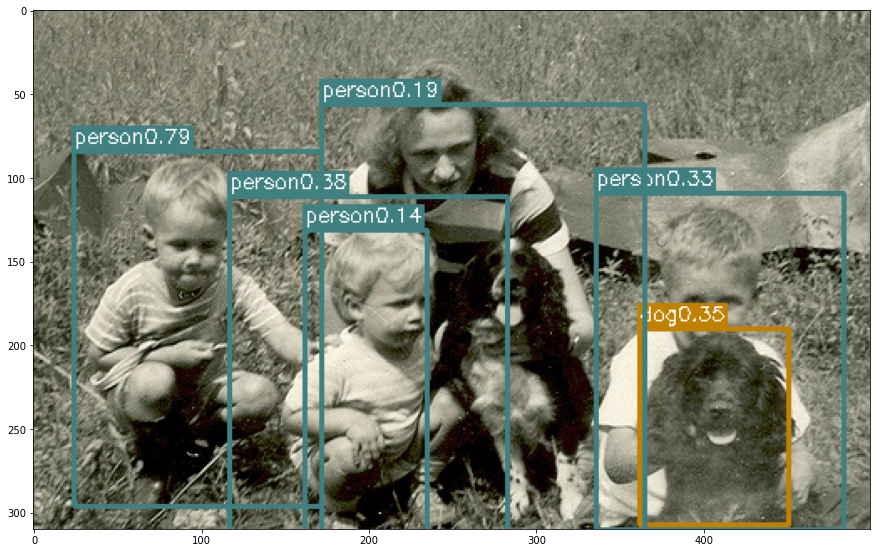

In [10]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [11]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test)

---Evaluate model on test samples---


100%|██████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:35<00:00, 31.79it/s]


---class aeroplane ap 0.5352900174432971---
---class bicycle ap 0.6335592431913784---
---class bird ap 0.5387581045697483---
---class boat ap 0.28355504220151023---
---class bottle ap 0.2573056847736956---
---class bus ap 0.6473556218325267---
---class car ap 0.6943787064663378---
---class cat ap 0.7074850870452833---
---class chair ap 0.30946662921244966---
---class cow ap 0.576450544116456---
---class diningtable ap 0.3864492836625337---
---class dog ap 0.6297963062938732---
---class horse ap 0.6874183375183067---
---class motorbike ap 0.6327913194185217---
---class person ap 0.5739780839761537---
---class pottedplant ap 0.21212462631944667---
---class sheep ap 0.46526125677409236---
---class sofa ap 0.5048238949770311---
---class train ap 0.6511643270700493---
---class tvmonitor ap 0.4943055934864307---
---map 0.521085885517456---


In [13]:
output_submission_csv('my_solution.csv', test_aps)

predicting...


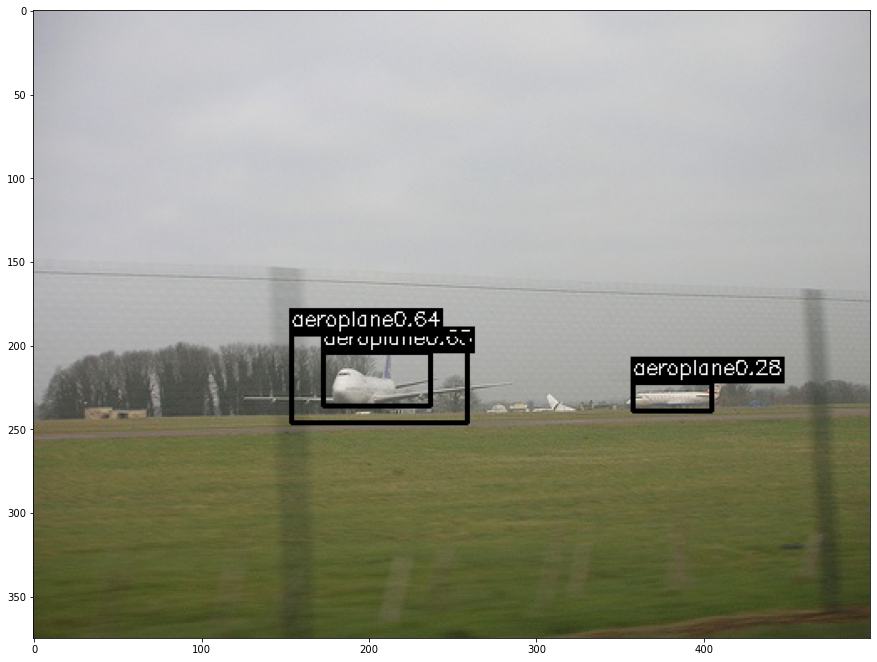

In [15]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)